In [1]:
%load_ext autoreload

# Gaussian Mixture Model

In [2]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.features, plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from feature_extraction import feature_extraction, preprocessing, PCA

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
df = db.query("^MKI.(A|B).*B1:.*", resample_to='1min', filters=True)
df_elogbook = db.query("MKI.ELOGBOOK$")
# marker column is to plot it together with other data
df_elogbook['marker'] = 0
display(df.shape, df.head(), df_elogbook.head())

Fetching data for pattern ^MKI.(A|B).*B1:.* from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.B5L2.B1:PRESSURE
Fetching data for MKI.B5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.A5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.B5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.A5L2.B1:PRESSURE
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_DOWN
Fetching data for pattern MKI.ELOGBOOK$ from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK


(216000, 10)

MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.B5L2.B1:PRESSURE  \
2016-04-16 22:00:00                        21.0          7.500000e-11   
2016-04-16 22:01:00                        21.0          7.500000e-11   
2016-04-16 22:02:00                        21.0          7.500000e-11   
2016-04-16 22:03:00                        21.0          7.500000e-11   
2016-04-16 22:04:00                        21.0          7.500000e-11   

                     MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
2016-04-16 22:00:00                        21.0                        22.1   
2016-04-16 22:01:00                        21.0                        22.1   
2016-04-16 22:02:00                        21.0                        22.1   
2016-04-16 22:03:00                        21.0                        22.1   
2016-04-16 22:04:00                        21.0                        22.1   

                     MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
2016-04-16 22:00:00                          20.7                      21.0   
2016-04-16 22:01:00                          20.7                      21.0   
2016-04-16 22:02:00                          20.7                      21.0   
2016-04-16 22:03:00                          20.7                      21.0   
2016-04-16 22:04:00                          20.7                      21.0   

                     MKI.A5L2.B1:TEMP_TUBE_UP  MKI.B5L2.B1:TEMP_MAGNET_UP  \
2016-04-16 22:00:00                      21.0                        20.3   
2016-04-16 22:01:00                      21.0                        20.3   
2016-04-16 22:02:00                      21.0                        20.3   
2016-04-16 22:03:00                      21.0                        20.3   
2016-04-16 22:04:00                      21.0                        20.3   

                     MKI.A5L2.B1:PRESSURE  MKI.A5L2.B1:TEMP_MAGNET_DOWN  
2016-04-16 22:00:00          2.100000e-11                          22.3  
2016-04-16 22:01:00          2.100000e-11                          22.3  
2016-04-16 22:02:00          2.100000e-11                          22.3  
2016-04-16 22:03:00          2.100000e-11                          22.3  
2016-04-16 22:04:00          2.100000e-11                          22.3

MKI.ELOGBOOK  marker
2016-04-23 04:00:00  {'TAG': 'KEY', 'VALUE': 'MKI8', 'EVENT_ID': '2...       0
2016-04-23 10:15:28  {'TAG': 'KEY', 'VALUE': 'MKI8', 'EVENT_ID': '2...       0
2016-04-24 05:19:36  {'TAG': 'KEY', 'VALUE': 'MKI8', 'EVENT_ID': '2...       0
2016-04-24 12:03:20  {'TAG': 'KEY', 'VALUE': 'MKI8', 'EVENT_ID': '2...       0
2016-04-26 10:00:00  {'TAG': 'KEY', 'VALUE': 'MKI8', 'EVENT_ID': '2...       0

## Feature extraction

Noticed during feature building: data on 2016-05-02 between 10:11:00 and 10:27:00 is missing

MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.B5L2.B1:PRESSURE  \
2016-05-02 10:10:00                        20.7          7.950000e-11   
2016-05-02 10:11:00                        20.7          7.966667e-11   
2016-05-02 10:12:00                        20.7          8.100000e-11   
2016-05-02 10:13:00                        20.7          8.100000e-11   
2016-05-02 10:14:00                        20.7          7.850000e-11   
2016-05-02 10:15:00                        20.7          7.700000e-11   

                     MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
2016-05-02 10:10:00                        20.7                        21.8   
2016-05-02 10:11:00                        20.7                        21.8   
2016-05-02 10:12:00                        20.7                        21.8   
2016-05-02 10:13:00                        20.7                        21.8   
2016-05-02 10:14:00                        20.7                        21.8   
2016-05-02 10:15:00                        20.7                        21.8   

                     MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
2016-05-02 10:10:00                          20.5                      20.7   
2016-05-02 10:11:00                          20.5                      20.7   
2016-05-02 10:12:00                          20.5                      20.7   
2016-05-02 10:13:00                          20.5                      20.7   
2016-05-02 10:14:00                          20.5                      20.7   
2016-05-02 10:15:00                          20.5                      20.7   

                     MKI.A5L2.B1:TEMP_TUBE_UP  MKI.B5L2.B1:TEMP_MAGNET_UP  \
2016-05-02 10:10:00                      20.7                        19.8   
2016-05-02 10:11:00                      20.7                        19.8   
2016-05-02 10:12:00                      20.7                        19.8   
2016-05-02 10:13:00                      20.7                        19.8   
2016-05-02 10:14:00                      20.7                        19.8   
2016-05-02 10:15:00                      20.7                        19.8   

                     MKI.A5L2.B1:PRESSURE  MKI.A5L2.B1:TEMP_MAGNET_DOWN  
2016-05-02 10:10:00          2.600000e-11                          22.1  
2016-05-02 10:11:00          2.600000e-11                          22.1  
2016-05-02 10:12:00          2.600000e-11                          22.1  
2016-05-02 10:13:00          2.600000e-11                          22.1  
2016-05-02 10:14:00          2.600000e-11                          22.1  
2016-05-02 10:15:00          2.600000e-11                          22.1

MKI.ELOGBOOK  marker
2016-05-02 10:00:00  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-05-02 12:59:00  {'TAG': 'KEY', 'VALUE': 'MKI8', 'EVENT_ID': '2...       0
2016-05-03 06:30:00  {'TAG': 'KEY', 'VALUE': 'MKI8', 'EVENT_ID': '2...       0
2016-05-03 08:50:00  {'TAG': 'KEY', 'VALUE': 'MKI8', 'EVENT_ID': '2...       0

{'C0': '9',
 'EVENTDATE': '02/05/2016 14:59:00',
 'EVENT_ID': '2104506',
 'PATH': 'LHC.MKI8',
 'SUBSTR_COMMENT_512_': "Stopped the MKI8 today around 12.00 am to 'burn' the EPROM to ensure the latest modifications (specifically to the INJECTION_PERMIT) are now inside the PLC. \n\nPut SYSTEM back in STANDBY (with correct masks applied where required). \n\nALL good.",
 'TAG': 'KEY',
 'USERNAME': 'roger.andrew.barlow@cern.ch',
 'VALUE': 'MKI8'}

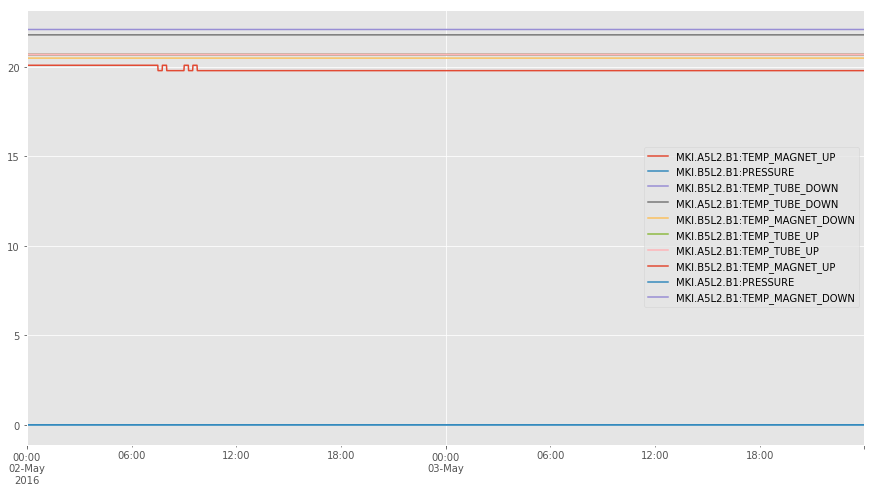

In [4]:
display(df['2016-5-2 10:10':'2016-5-2 10:15'])
display(df_elogbook['2016-5-2':'2016-5-3'])
display(df_elogbook.loc['2016-05-02 12:59:00', "MKI.ELOGBOOK"][0])
df['2016-05-02':'2016-05-03'].plot()

Reindex to fill the gap

In [5]:
new_index = pd.date_range(start=df.index[0], end=df.index[-1], freq='1T')
new_index.name = "timestamps"
df = df.reindex(new_index, method='bfill')

In [6]:
new_index

DatetimeIndex(['2016-04-16 22:00:00', '2016-04-16 22:01:00',
               '2016-04-16 22:02:00', '2016-04-16 22:03:00',
               '2016-04-16 22:04:00', '2016-04-16 22:05:00',
               '2016-04-16 22:06:00', '2016-04-16 22:07:00',
               '2016-04-16 22:08:00', '2016-04-16 22:09:00',
               ...
               '2016-09-13 21:50:00', '2016-09-13 21:51:00',
               '2016-09-13 21:52:00', '2016-09-13 21:53:00',
               '2016-09-13 21:54:00', '2016-09-13 21:55:00',
               '2016-09-13 21:56:00', '2016-09-13 21:57:00',
               '2016-09-13 21:58:00', '2016-09-13 21:59:00'],
              dtype='datetime64[ns]', name='timestamps', length=216000, freq='T')

In [7]:
df.head()

MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.B5L2.B1:PRESSURE  \
timestamps                                                              
2016-04-16 22:00:00                        21.0          7.500000e-11   
2016-04-16 22:01:00                        21.0          7.500000e-11   
2016-04-16 22:02:00                        21.0          7.500000e-11   
2016-04-16 22:03:00                        21.0          7.500000e-11   
2016-04-16 22:04:00                        21.0          7.500000e-11   

                     MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
timestamps                                                                    
2016-04-16 22:00:00                        21.0                        22.1   
2016-04-16 22:01:00                        21.0                        22.1   
2016-04-16 22:02:00                        21.0                        22.1   
2016-04-16 22:03:00                        21.0                        22.1   
2016-04-16 22:04:00                        21.0                        22.1   

                     MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
timestamps                                                                    
2016-04-16 22:00:00                          20.7                      21.0   
2016-04-16 22:01:00                          20.7                      21.0   
2016-04-16 22:02:00                          20.7                      21.0   
2016-04-16 22:03:00                          20.7                      21.0   
2016-04-16 22:04:00                          20.7                      21.0   

                     MKI.A5L2.B1:TEMP_TUBE_UP  MKI.B5L2.B1:TEMP_MAGNET_UP  \
timestamps                                                                  
2016-04-16 22:00:00                      21.0                        20.3   
2016-04-16 22:01:00                      21.0                        20.3   
2016-04-16 22:02:00                      21.0                        20.3   
2016-04-16 22:03:00                      21.0                        20.3   
2016-04-16 22:04:00                      21.0                        20.3   

                     MKI.A5L2.B1:PRESSURE  MKI.A5L2.B1:TEMP_MAGNET_DOWN  
timestamps                                                               
2016-04-16 22:00:00          2.100000e-11                          22.3  
2016-04-16 22:01:00          2.100000e-11                          22.3  
2016-04-16 22:02:00          2.100000e-11                          22.3  
2016-04-16 22:03:00          2.100000e-11                          22.3  
2016-04-16 22:04:00          2.100000e-11                          22.3

In [8]:
df.describe()

MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.B5L2.B1:PRESSURE  \
count               216000.000000          2.160000e+05   
mean                    32.125945          1.704354e-10   
std                      8.616805          1.478145e-10   
min                     20.700000          4.400000e-11   
25%                     23.400000          7.450000e-11   
50%                     32.300000          9.850000e-11   
75%                     40.200000          2.110000e-10   
max                     49.000000          3.889286e-09   

       MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
count               216000.000000                216000.00000   
mean                    29.629508                    32.27925   
std                      7.257422                     8.55413   
min                     20.700000                    21.60000   
25%                     22.500000                    23.80000   
50%                     28.100000                    30.30000   
75%                     36.800000                    40.70000   
max                     44.300000                    49.70000   

       MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
count                 216000.000000             216000.000000   
mean                      26.835483                 36.491022   
std                        4.563718                 13.986875   
min                       20.300000                 20.500000   
25%                       22.300000                 23.800000   
50%                       27.200000                 35.000000   
75%                       31.200000                 44.100000   
max                       34.800000                 86.000000   

       MKI.A5L2.B1:TEMP_TUBE_UP  MKI.B5L2.B1:TEMP_MAGNET_UP  \
count             216000.000000                216000.00000   
mean                  48.713075                    30.52977   
std                   24.994437                     8.03593   
min                   20.500000                    19.80000   
25%                   24.300000                    22.50000   
50%                   42.200000                    30.90000   
75%                   73.700000                    37.97500   
max                  102.500000                    46.10000   

       MKI.A5L2.B1:PRESSURE  MKI.A5L2.B1:TEMP_MAGNET_DOWN  
count          2.160000e+05                 216000.000000  
mean           4.832735e-11                     29.482616  
std            3.110729e-11                      5.314283  
min            1.700000e-11                     22.100000  
25%            2.700000e-11                     24.300000  
50%            3.500000e-11                     29.800000  
75%            6.300000e-11                     34.500000  
max            2.677000e-09                     39.100000

In [9]:
# create features: sliding window mean, diff and sum
# 10 min windows
SWM_T10 = feature_extraction.sliding_window_mean(df, "min", 10)
SWMD_T10 = feature_extraction.sliding_window_mean_diff(df, "min", 10)
SWS_T10 = feature_extraction.sliding_window_sum(df, "min", 10)
features = pd.concat([df, SWM_T10, SWMD_T10, SWS_T10], axis=1)
features.shape

(216000, 40)

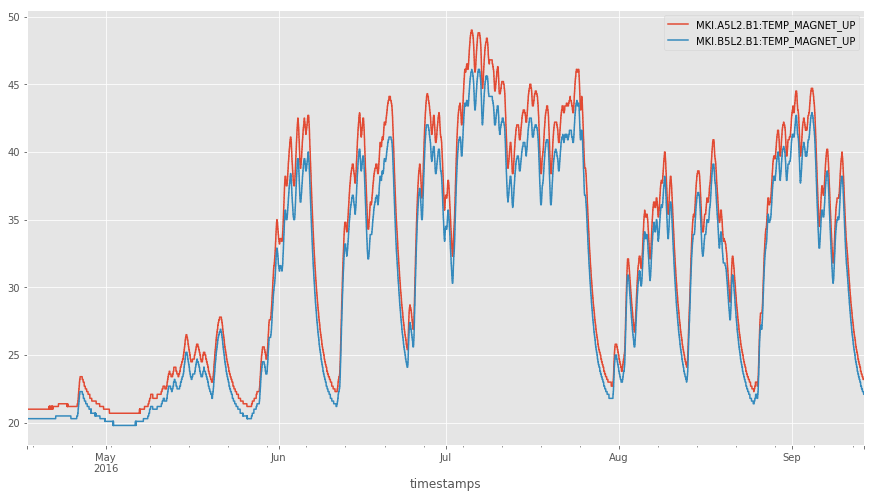

In [10]:
features[['MKI.A5L2.B1:TEMP_MAGNET_UP', 'MKI.B5L2.B1:TEMP_MAGNET_UP']].plot()

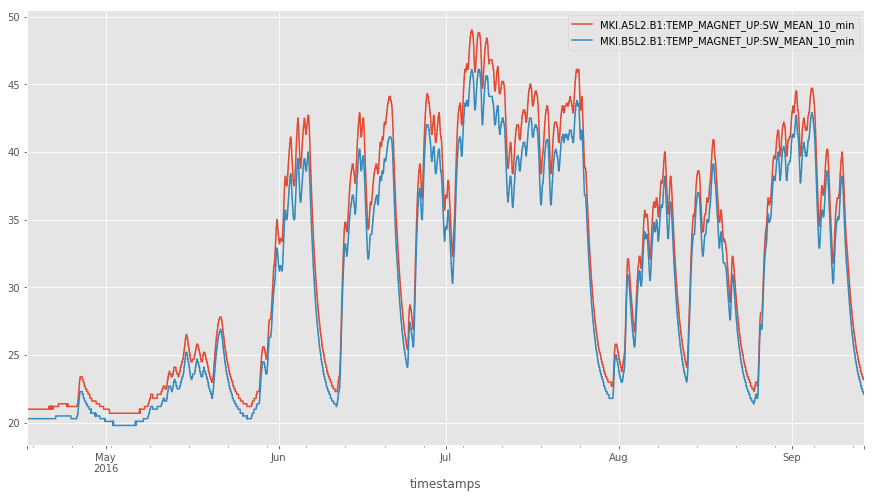

In [11]:
SWM_T10[['MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_10_min', 'MKI.B5L2.B1:TEMP_MAGNET_UP:SW_MEAN_10_min']].plot()

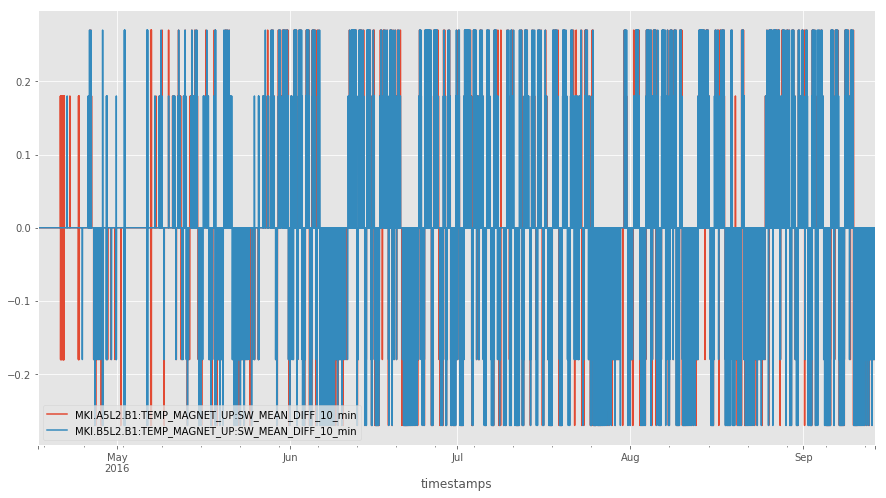

In [12]:
SWMD_T10[['MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_10_min', 'MKI.B5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_10_min']].plot()

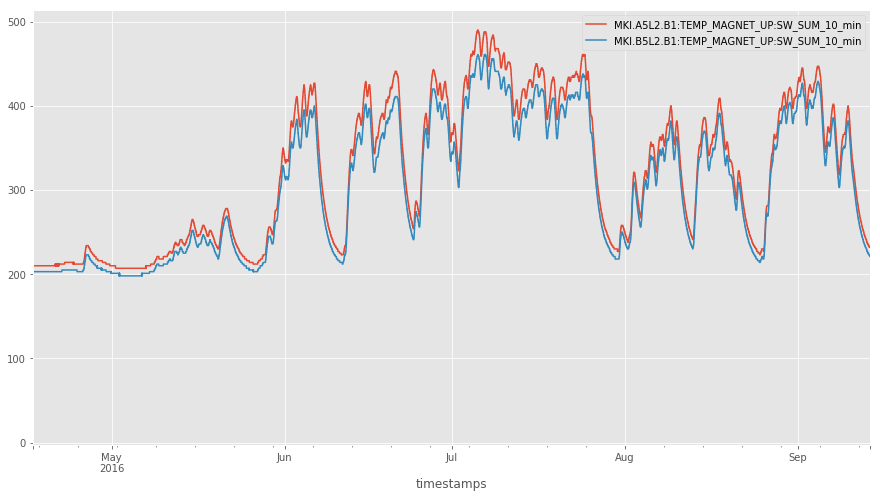

In [13]:
SWS_T10[['MKI.A5L2.B1:TEMP_MAGNET_UP:SW_SUM_10_min', 'MKI.B5L2.B1:TEMP_MAGNET_UP:SW_SUM_10_min']].plot()

In [14]:
dfs = preprocessing.scale_robust(features)
display(dfs.shape, dfs.describe())

(216000, 40)

MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.B5L2.B1:PRESSURE  \
count               216000.000000         216000.000000   
mean                    -0.010360              0.526999   
std                      0.512905              1.082890   
min                     -0.690476             -0.399267   
25%                     -0.529762             -0.175824   
50%                      0.000000              0.000000   
75%                      0.470238              0.824176   
max                      0.994048             27.771324   

       MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
count               216000.000000               216000.000000   
mean                     0.106959                    0.117115   
std                      0.507512                    0.506162   
min                     -0.517483                   -0.514793   
25%                     -0.391608                   -0.384615   
50%                      0.000000                    0.000000   
75%                      0.608392                    0.615385   
max                      1.132867                    1.147929   

       MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
count                 216000.000000             216000.000000   
mean                      -0.040957                  0.073449   
std                        0.512777                  0.689009   
min                       -0.775281                 -0.714286   
25%                       -0.550562                 -0.551724   
50%                        0.000000                  0.000000   
75%                        0.449438                  0.448276   
max                        0.853933                  2.512315   

       MKI.A5L2.B1:TEMP_TUBE_UP  MKI.B5L2.B1:TEMP_MAGNET_UP  \
count             216000.000000               216000.000000   
mean                   0.131844                   -0.023924   
std                    0.505960                    0.519285   
min                   -0.439271                   -0.717286   
25%                   -0.362348                   -0.542811   
50%                    0.000000                    0.000000   
75%                    0.637652                    0.457189   
max                    1.220648                    0.982229   

       MKI.A5L2.B1:PRESSURE  MKI.A5L2.B1:TEMP_MAGNET_DOWN  \
count         216000.000000                 216000.000000   
mean               0.370204                     -0.031116   
std                0.864091                      0.521008   
min               -0.500000                     -0.754902   
25%               -0.222222                     -0.539216   
50%                0.000000                      0.000000   
75%                0.777778                      0.460784   
max               73.388889                      0.911765   

                          ...                      \
count                     ...                       
mean                      ...                       
std                       ...                       
min                       ...                       
25%                       ...                       
50%                       ...                       
75%                       ...                       
max                       ...                       

       MKI.A5L2.B1:TEMP_MAGNET_UP:SW_SUM_10_min  \
count                             216000.000000   
mean                                  -0.010439   
std                                    0.515413   
min                                   -1.806220   
25%                                   -0.531100   
50%                                    0.000000   
75%                                    0.468900   
max                                    0.998804   

       MKI.B5L2.B1:PRESSURE:SW_SUM_10_min  \
count                       216000.000000   
mean                             0.527334   
std                              1.076793   
min                             -0.665443   
25%                   

## GMM

Fitting models for cv_type 'full'
Done with components: 1 2 3 
Fitting models for cv_type 'tied'
Done with components: 1 2 3 
Fitting models for cv_type 'diag'
Done with components: 1 2 3 
Fitting models for cv_type 'spherical'
Done with components: 1 2 3 


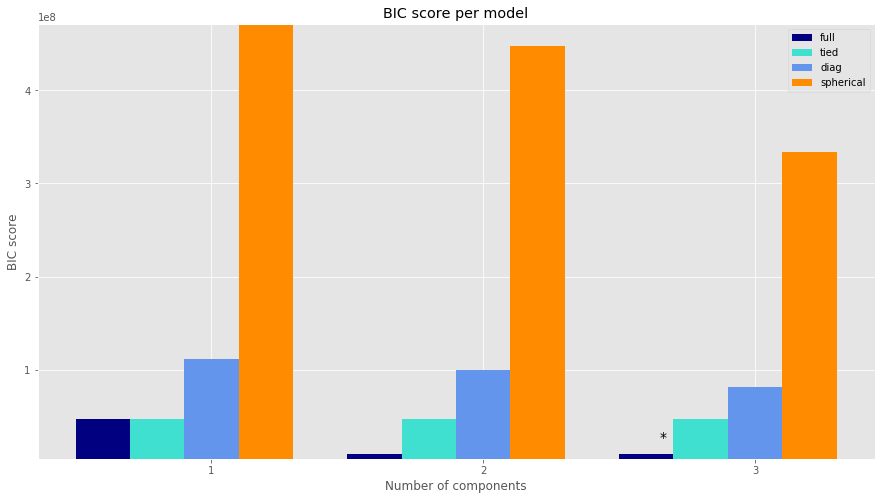

In [17]:
bic_scores = GMM.bic_scores(dfs, max_n_components=3)
plot.features.gmm_bic_scores(bic_scores, max_n_components=3)

3 components, trying above 3 gives:

ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

In [19]:
clf = GMM.GMM(n_components=3, covariance_type='full')
# this will give an error sometimes, try again
clf.fit(dfs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

## Anomaly Detection

'Log probs shape: 216000'

'Log probs mean: -21.52452350465663'

'Log probs min: -23117.140901629344'

'Log probs max: 16.125239499356603'

'1pct percentile: -125'

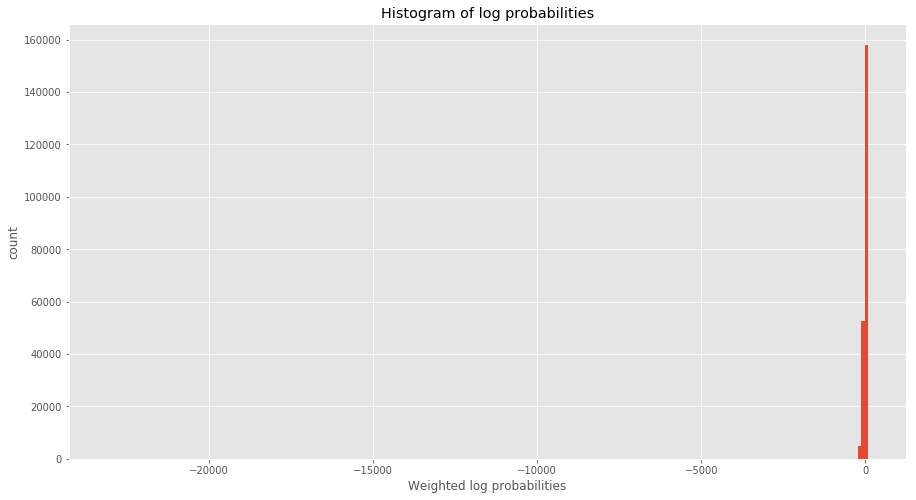

In [20]:
# Compute the weighted log probabilities for each sample, 1-dim ndarray is returned
log_probs = clf.anomaly_scores(dfs)
display("Log probs shape: %s" % log_probs.shape)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())
pct = np.percentile(log_probs, 1)
display("1pct percentile: %d" % pct)
# np.where returns an array with the element positions where the condition is true
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]
binwidth = 100
plt.figure()
plt.hist(log_probs, bins=np.arange(min(log_probs), max(log_probs) + binwidth, binwidth));
plt.title("Histogram of log probabilities")
plt.xlabel('Weighted log probabilities')
plt.ylabel('count')

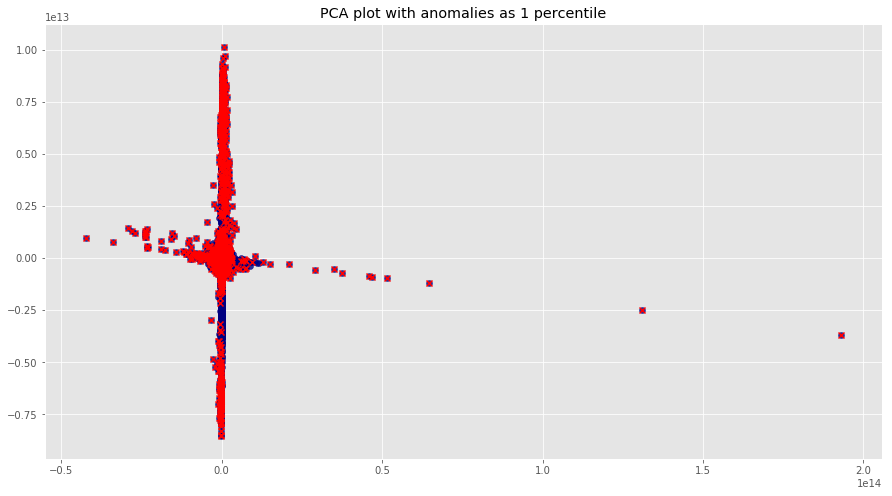

In [21]:
p = PCA.PCA()
p_data = p.transform(dfs)
p.plot_anomalies(p_data, idx[0], "PCA plot with anomalies as 1 percentile")

1 percentile data is too much for anomalies, but already shows how they are spread out. All but 1 outliers in PCA are detected.

In [22]:
display(p.PCA.components_)
component1 = p.PCA.components_[0]
# select components with most variance
c_idx = list(np.where((abs(component1) > 1e-4))[0])
display(c_idx)
display(np.array(dfs.columns.values)[c_idx])

array([[-1.79092737e-15,  7.96558557e-15, -1.43325161e-14,
        -1.62212465e-14, -1.78899539e-15,  3.67172231e-15,
        -1.40334318e-14, -1.93341852e-15,  3.21534935e-13,
        -1.76233821e-15, -1.81460948e-15, -1.39050704e-14,
        -1.41647896e-14, -1.62701897e-14, -1.76034330e-15,
         4.88808671e-15, -1.40694167e-14, -1.90329607e-15,
        -2.12868407e-14, -1.71930254e-15, -3.80934014e-03,
         1.48579337e-12, -3.66908764e-03,  9.07536590e-04,
        -2.24303308e-03, -1.86754347e-02,  6.73041052e-14,
        -2.75843581e-03,  9.99795138e-01, -4.41276187e-03,
        -1.81460949e-15, -1.39050704e-14, -1.41647896e-14,
        -1.62701897e-14, -1.76034332e-15,  4.88808670e-15,
        -1.40694167e-14, -1.90329608e-15, -2.12868407e-14,
        -1.71930256e-15],
       [ 3.22612975e-15, -8.49423426e-14, -1.21287290e-13,
        -1.23622771e-13,  6.28873107e-15, -7.12109288e-14,
        -1.25066528e-13,  1.89608213e-15, -5.14811745e-14,
         7.35733053e-15,  4.66

[20, 22, 23, 24, 25, 27, 28, 29]

array(['MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_10_min',
       'MKI.B5L2.B1:TEMP_TUBE_DOWN:SW_MEAN_DIFF_10_min',
       'MKI.A5L2.B1:TEMP_TUBE_DOWN:SW_MEAN_DIFF_10_min',
       'MKI.B5L2.B1:TEMP_MAGNET_DOWN:SW_MEAN_DIFF_10_min',
       'MKI.B5L2.B1:TEMP_TUBE_UP:SW_MEAN_DIFF_10_min',
       'MKI.B5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_10_min',
       'MKI.A5L2.B1:PRESSURE:SW_MEAN_DIFF_10_min',
       'MKI.A5L2.B1:TEMP_MAGNET_DOWN:SW_MEAN_DIFF_10_min'], dtype=object)

Plot shows how the log probabilities change over time. All red X'es mark an event in the e-logbook.

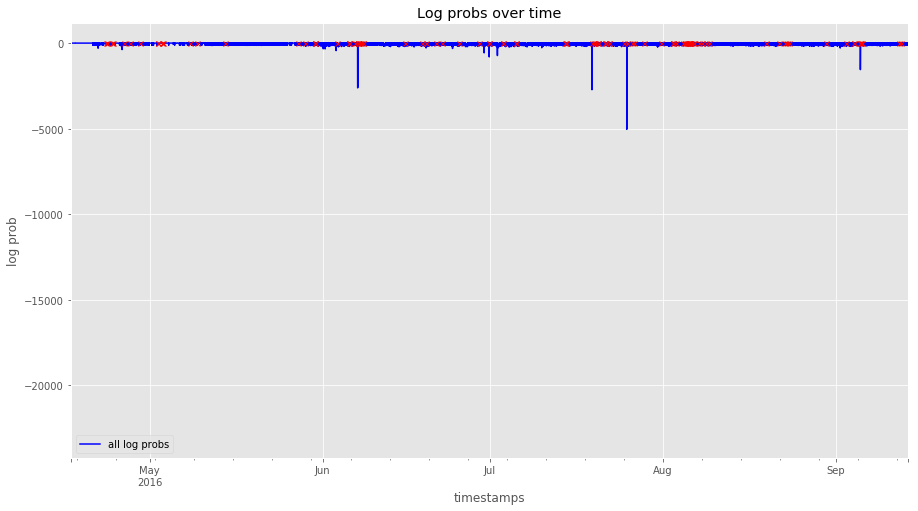

In [23]:
log_probs_df = pd.DataFrame(data=log_probs, index=dfs.index)

fig, axes = plt.subplots()
log_probs_df.plot(ax=axes, color='b')
df_elogbook.plot(ax=axes, linestyle='none', marker='x', markersize=5, color='red')
labels = ["all log probs"]
axes.legend(labels)
axes.set_ylabel("log prob")
axes.set_title("Log probs over time")

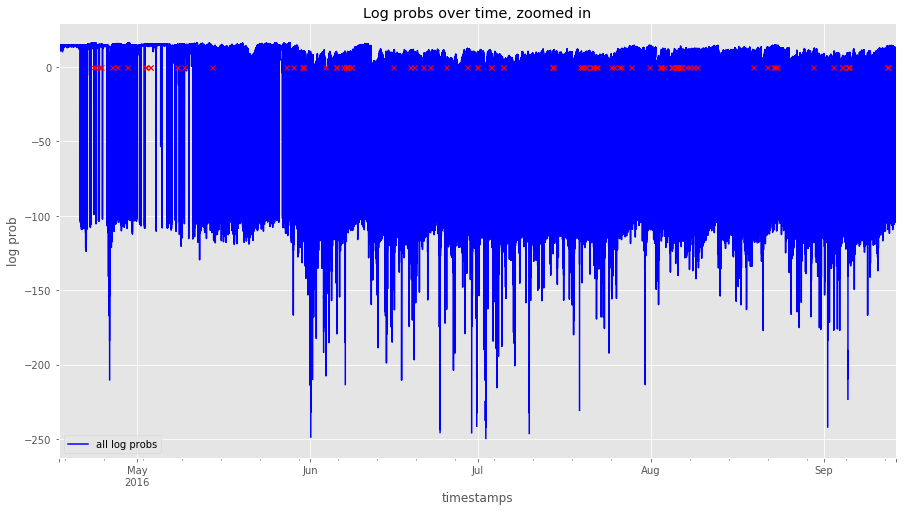

In [24]:
log_probs_df2 = log_probs_df[log_probs_df>-250]

fig, axes = plt.subplots()
log_probs_df2.plot(ax=axes, color='b')
df_elogbook.plot(ax=axes, linestyle='none', marker='x', markersize=5, color='red')
labels = ["all log probs"]
axes.legend(labels)
axes.set_ylabel("log prob")
axes.set_title("Log probs over time, zoomed in")

Markers don't seem to directly correspond with possible anomalies.
Interesting: many markers first quarter of August.

In [25]:
display(df_elogbook['2016-8-1':'2016-8-15'])
df_elogbook.loc['2016-08-05 07:29:20', "MKI.ELOGBOOK"][0]

MKI.ELOGBOOK  marker
2016-08-02 17:28:00  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-02 17:50:00  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-02 19:53:00  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-03 08:05:00  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-04 14:03:41  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-04 20:37:49  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-04 22:21:09  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-05 07:29:20  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-05 13:03:07  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-05 14:09:02  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-05 15:19:18  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-05 16:42:30  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-05 19:10:15  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-05 20:13:52  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-06 01:17:53  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-06 10:11:31  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-06 11:22:33  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-07 10:44:07  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-07 22:46:55  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-08 16:00:38  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0
2016-08-09 06:22:26  {'TAG': 'KEY', 'VALUE': 'MKI2', 'EVENT_ID': '2...       0

{'C0': '72',
 'EVENTDATE': '05/08/2016 09:29:20',
 'EVENT_ID': '2156897',
 'PATH': 'LHC.MKI2',
 'SUBSTR_COMMENT_512_': 'Asked OP (Jörg, Matteo) to move the intermediate softstart further away from the beginning of the ramp down sequence. Currently the softstart is executed ~1-2min after the dump which is still in the decay of the higher vacuum level after operation with beam.',
 'TAG': 'KEY',
 'USERNAME': 'tkramer',
 'VALUE': 'MKI2'}

In [26]:
top50 = np.argpartition(log_probs, 50) #first 50 elements will be the indexes of smallest elements
top50 = top50[:50]

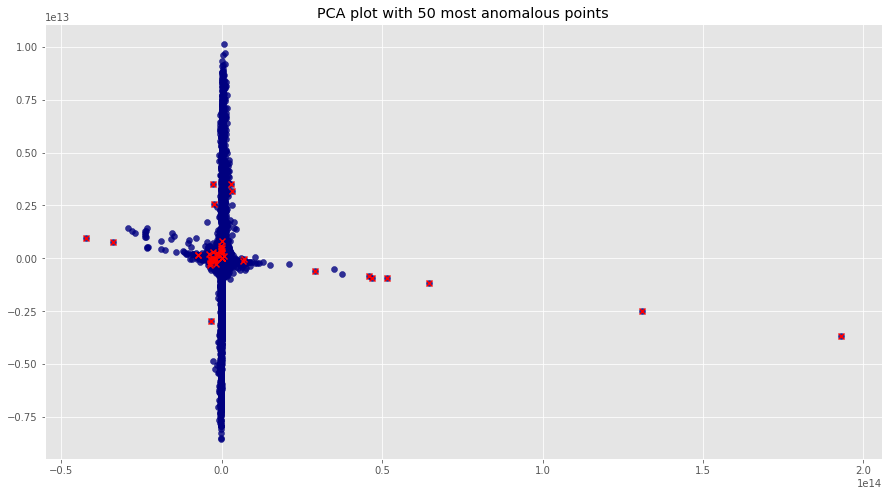

In [27]:
p.plot_anomalies(p_data, top50, "PCA plot with 50 most anomalous points")

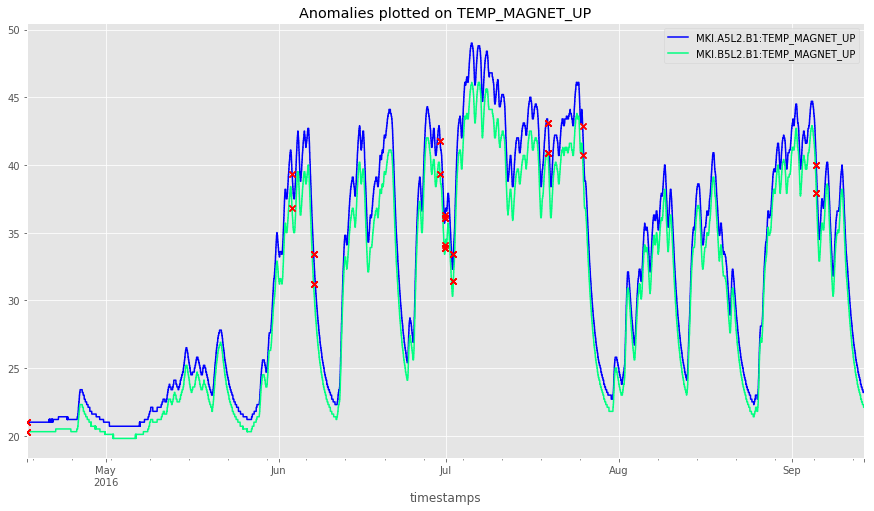

In [31]:
plot.anomalies.anomalies_timeseries(df, "TEMP_MAGNET_UP", top50, "Anomalies plotted on TEMP_MAGNET_UP")

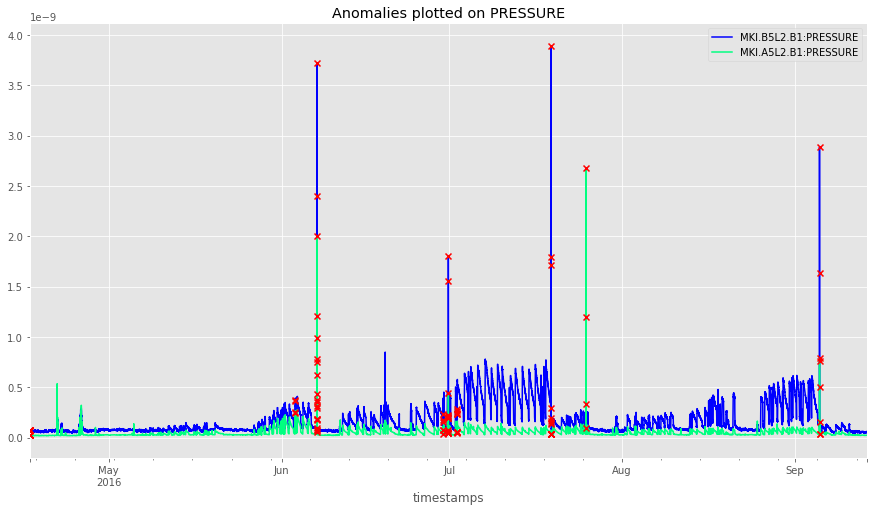

In [32]:
plot.anomalies.anomalies_timeseries(df, "PRESSURE", top50, "Anomalies plotted on PRESSURE")